# Réseau récurrent pour la prévision de données temporelles

L'objectif de ce notebook est de construire un réseau récurrent simple (sans module LSTM ou GRU) permettant de faire de la prévision méteo à partir de données de température, pression et humidité mesurées pendant 5 ans.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN,LSTM,GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Données

Les [données](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) sont des mesures de divers paramètres relatifs à la météo (températire, pression, humidité relative) acquis chaque heure entre 2012 et 2017 dans 36 villes (US, Canada et quelques autres grandes villes du monde)

In [3]:
humidity = pd.read_csv("../../data/meteo/humidity.csv")
temp = pd.read_csv("../../data/meteo/temperature.csv")
pressure = pd.read_csv("../../data/meteo/pressure.csv")

In [4]:
ville='Montreal'
humidity_M = humidity[['datetime',ville]]
temp_M = temp[['datetime',ville]]
pressure_M = pressure[['datetime',ville]]

### Données d'entraînement


Quelques mesures sont manquantes. Plutôt que de les éliminer, on choisit d'interpoler les points (les variations des paramètres étant relativement lents)

In [5]:
print(humidity_M.isna().sum()[ville],"données manquantes d'humidité sur",humidity_M.shape[0])
print(temp_M.isna().sum()[ville],"données manquantes de température sur",temp_M.shape[0])
print(pressure_M.isna().sum()[ville],"données manquantes de pression sur",pressure_M.shape[0])

1696 données manquantes d'humidité sur 45253
3 données manquantes de température sur 45253
994 données manquantes de pression sur 45253


In [6]:
humidity_M.interpolate(inplace=True)
humidity_M.dropna(inplace=True)

temp_M.interpolate(inplace=True)
temp_M.dropna(inplace=True)

pressure_M.interpolate(inplace=True)
pressure_M.dropna(inplace=True)

Les données d'entraînement sont constituées de `nb_samples` points de mesure, pris au début des données. la prévision se fera sur les 45253-`nb_samples`points restants

In [7]:
nb_samples = 5000

humidity_train = np.array(humidity_M[ville][:nb_samples]).ravel()
humidity_test = np.array(humidity_M[ville][nb_samples:]).ravel()

temp_train = np.array(temp_M[ville][:nb_samples]).ravel()
temp_test = np.array(temp_M[ville][nb_samples:]).ravel()

pressure_train = np.array(pressure_M[ville][:nb_samples]).ravel()
pressure_test = np.array(pressure_M[ville][nb_samples:]).ravel()


In [8]:
def plot_train_points(ville=ville,nb_samples=nb_samples):
    plt.figure(figsize=(15,8))
    plt.subplot(311)
    plt.title("Humidité à {0:s} sur les {1:d} premiers points".format(ville,nb_samples))
    plt.grid(True)

    plt.plot(humidity_train,c='r',lw=1)
    plt.subplot(312)
    plt.title("Température à {0:s} sur les {1:d} premiers points".format(ville,nb_samples))
    plt.plot(temp_train,c='g',lw=1)
    plt.grid(True)

    plt.subplot(313)
    plt.title("Pression à {0:s} sur les {1:d} premiers points".format(ville,nb_samples))
    plt.plot(pressure_train,c='b',lw=1)
    plt.grid(True)
    
    plt.tight_layout()

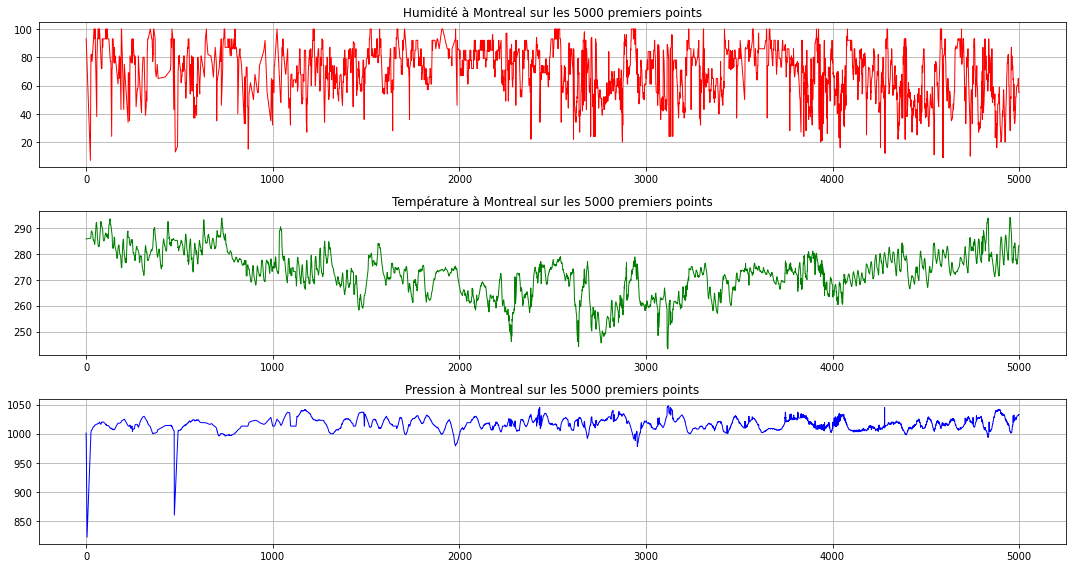

In [9]:
plot_train_points()

### Transformation des données pour le RNN

Un réseau récurrent prédit une valeur à partir des $n$ précédentes, n étant appelé l'embedding size. 

In [10]:
embedding_size = 8
saved=False

humidity_train = np.append(humidity_train,np.repeat(humidity_train[-1,],embedding_size))
humidity_test = np.append(humidity_test,np.repeat(humidity_test[-1,],embedding_size))

temp_train = np.append(temp_train,np.repeat(temp_train[-1,],embedding_size))
temp_test = np.append(temp_test,np.repeat(temp_test[-1,],embedding_size))

pressure_train = np.append(pressure_train,np.repeat(pressure_train[-1,],embedding_size))
pressure_test = np.append(pressure_test,np.repeat(pressure_test[-1,],embedding_size))

On convertit ensuite les données sous forme matricielle

In [11]:
def convertToMatrix(data, embedding_size):
    X, Y =[], []
    for i in range(len(data)-embedding_size):
        d=i+embedding_size  
        X.append(data[i:d,])
        Y.append(data[d,])
    X=np.array(X)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    Y=np.array(Y)
    return X,Y

In [12]:
humidity_trainX,humidity_trainY =convertToMatrix(humidity_train,embedding_size)
humidity_testX,humidity_testY =convertToMatrix(humidity_test,embedding_size)

temp_trainX,temp_trainY =convertToMatrix(temp_train,embedding_size)
temp_testX,temp_testY =convertToMatrix(temp_test,embedding_size)

pressure_trainX,pressure_trainY =convertToMatrix(pressure_train,embedding_size)
pressure_testX,pressure_testY =convertToMatrix(pressure_test,embedding_size)


## Réseau récurrent

On  utilise un RNN complètement connecté [(SimpleRNN de Keras)](https://keras.io/layers/recurrent/) suivi d'une sortie réelle (la prédiction)

In [13]:
def myRNN(num_units=128, embedding_size=embedding_size,num_dense=32,lr=0.0005):
#TODO
    return model

In [14]:
model_humidity = myRNN()
model_temp = myRNN()
model_pressure = myRNN()

model_humidity.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (SimpleRNN)              (None, 128)               17536     
_________________________________________________________________
Dense1 (Dense)               (None, 32)                4128      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 21,697
Trainable params: 21,697
Non-trainable params: 0
_________________________________________________________________


### Entraînement

In [17]:
batch_size=8
num_epochs = 1000


class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(epoch% 100==0):   
            print("epoch {0:d} MSE :{1:5.3f} ".format(epoch,logs.get('mse') ))

Entraînement Humidité
epoch 0 MSE :72.138 
epoch 100 MSE :56.962 
epoch 200 MSE :54.297 
epoch 300 MSE :52.759 
epoch 400 MSE :50.960 
epoch 500 MSE :50.359 
epoch 600 MSE :48.970 
epoch 700 MSE :48.773 
epoch 800 MSE :48.523 
epoch 900 MSE :47.216 
Entraînement Température
epoch 0 MSE :2906.382 
epoch 100 MSE :4.902 
epoch 200 MSE :3.804 
epoch 300 MSE :3.269 
epoch 400 MSE :2.849 
epoch 500 MSE :2.555 
epoch 600 MSE :2.380 
epoch 700 MSE :2.265 
epoch 800 MSE :2.217 
epoch 900 MSE :2.188 
Entraînement pression
epoch 0 MSE :9385.773 
epoch 100 MSE :62.040 
epoch 200 MSE :47.849 
epoch 300 MSE :40.003 
epoch 400 MSE :33.959 
epoch 500 MSE :30.851 
epoch 600 MSE :29.112 
epoch 700 MSE :27.578 
epoch 800 MSE :25.856 
epoch 900 MSE :25.325 


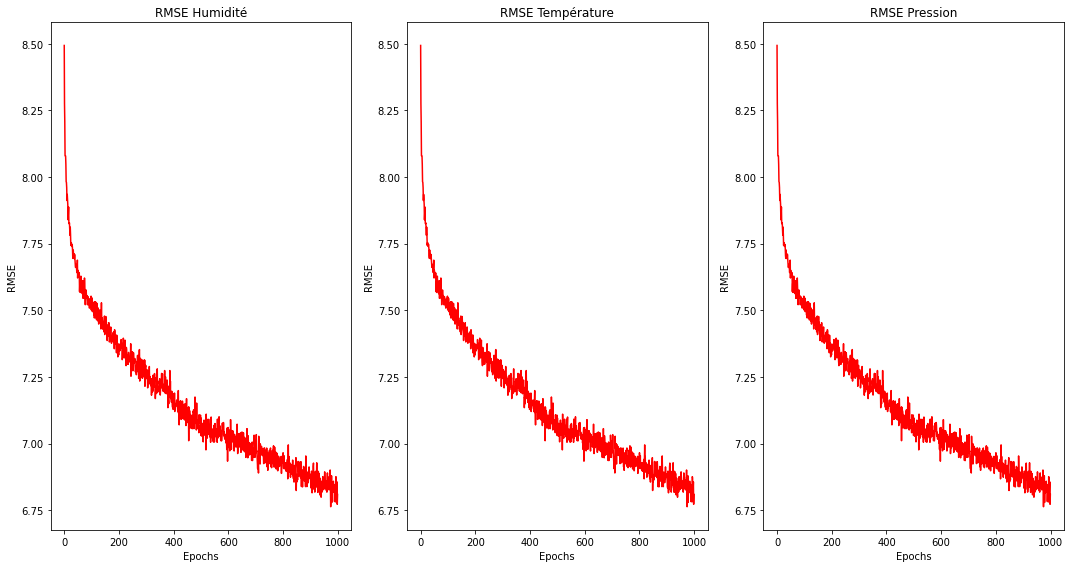

In [18]:
# Si déjà entrainé
#model_humidity.load_weights("model_humidity.h5")
#model_temp.load_weights("model_temp.h5")
#model_pressure.load_weights("model_pressure.h5")

print('Entraînement Humidité')
model_humidity.fit(humidity_trainX,humidity_trainY, epochs=num_epochs, 
          batch_size=batch_size, callbacks=[MyCallback()],verbose=0)
plt.figure(figsize=(15,8))
plt.subplot(131)    
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='r')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title('RMSE Humidité')


print('Entraînement Température')
model_temp.fit(temp_trainX,temp_trainY, epochs=num_epochs, 
          batch_size=batch_size, callbacks=[MyCallback()],verbose=0)
plt.subplot(132)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='r')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title('RMSE Température')

print('Entraînement pression')
model_pressure.fit(pressure_trainX,pressure_trainY, epochs=num_epochs, 
          batch_size=batch_size, callbacks=[MyCallback()],verbose=0)
plt.subplot(133)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='r')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title('RMSE Pression')
plt.tight_layout()


In [19]:
model_humidity.save_weights("model_humidity.h5")
model_temp.save_weights("model_temp.h5")
model_pressure.save_weights("model_pressure.h5")

## Prédiction

In [20]:
humidity_predicted=np.concatenate((model_humidity.predict(humidity_trainX),
                                   model_humidity.predict(humidity_testX)),axis=0)

temp_predicted=np.concatenate((model_temp.predict(temp_trainX),
                               model_temp.predict(temp_testX)),axis=0)
 
pressure_predicted=np.concatenate((model_pressure.predict(pressure_trainX),
                                   model_pressure.predict(pressure_testX)),axis=0)


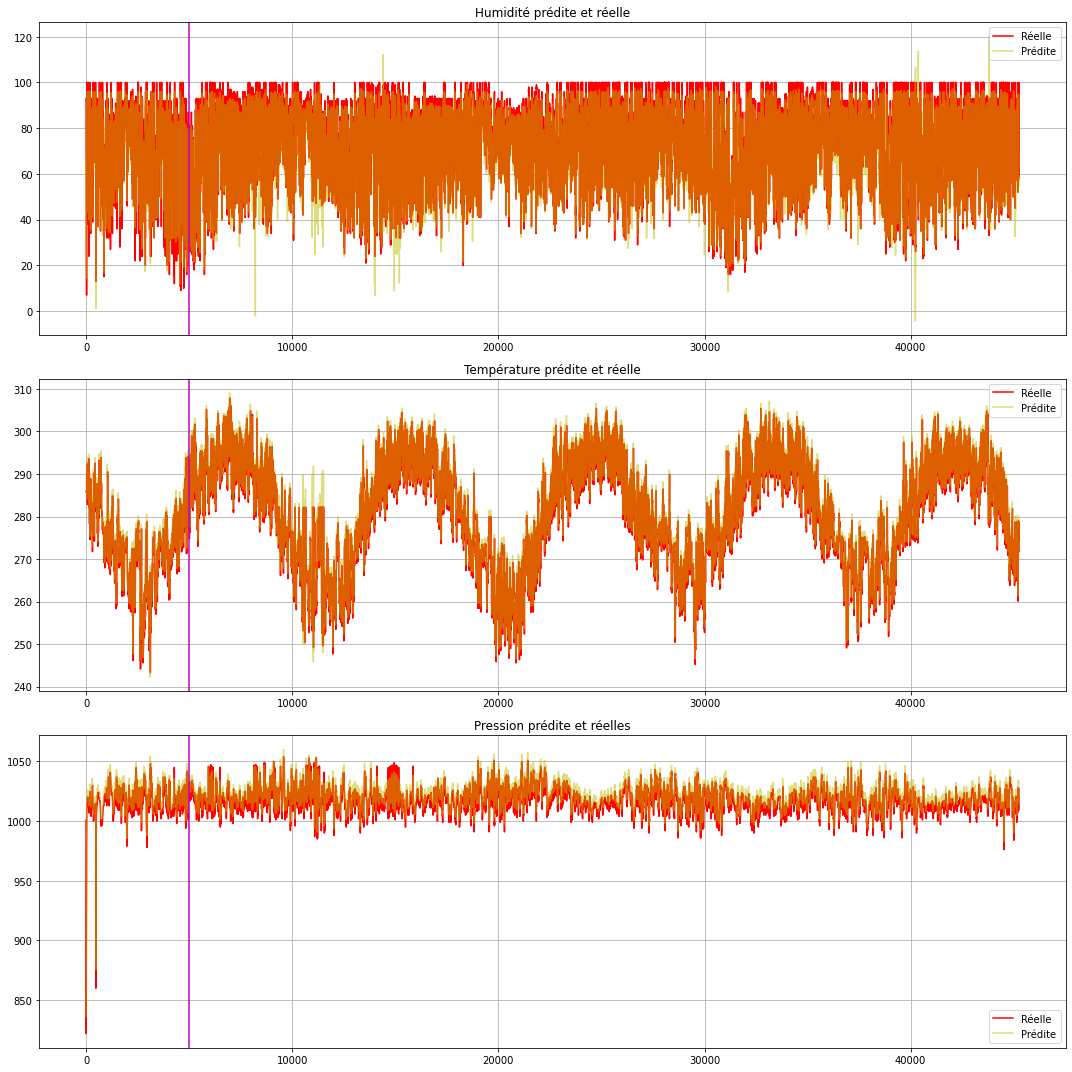

In [21]:

plt.figure(figsize=(15,15))

plt.subplot(311)
index = humidity_M.index.values
plt.title("Humidité prédite et réelle")
plt.plot(index,humidity_M[ville],'r')
plt.plot(index,humidity_predicted,'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)

plt.subplot(312)
index = temp_M.index.values
plt.title("Température prédite et réelle")
plt.plot(index,temp_M[ville],'r')
plt.plot(index,temp_predicted,'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)

plt.subplot(313)
index = pressure_M.index.values
plt.title("Pression prédite et réelles")
plt.plot(index,pressure_M[ville],'r')
plt.plot(index,pressure_predicted,'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)
    
plt.tight_layout()


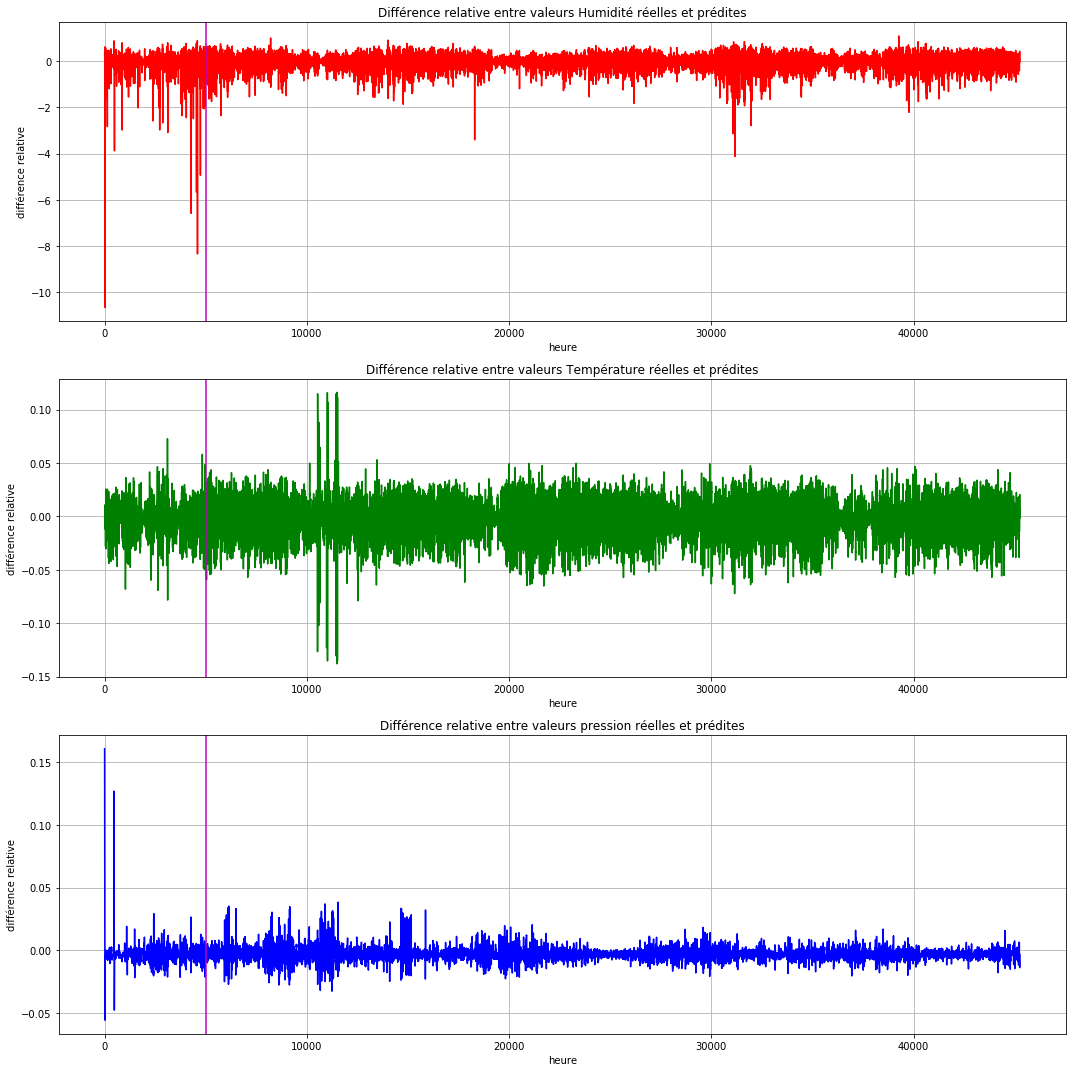

In [104]:
plt.figure(figsize=(15,15))
plt.subplot(311)
index = humidity_M.index.values
x = np.array(humidity_M[ville]).reshape(-1,1)
max = np.max(x)
plt.title("Différence relative entre valeurs Humidité réelles et prédites")
plt.plot(index,(x-humidity_predicted)/x,'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)

plt.subplot(312)
index = temp_M.index.values
x = np.array(temp_M[ville]).reshape(-1,1)
max = np.max(x)
plt.title("Différence relative entre valeurs Température réelles et prédites")
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.plot(index,(x-temp_predicted)/x,'g')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)

plt.subplot(313)
index = pressure_M.index.values
x = np.array(pressure_M[ville]).reshape(-1,1)
max = np.max(x)
plt.title("Différence relative entre valeurs pression réelles et prédites")
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.plot(index,(x-pressure_predicted)/max,'b')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
    
plt.tight_layout()

### Comparaison aux réseaux LSTM et GRU 


#### Comparaison LSTM

In [22]:
np.random.seed(42)


def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


#TODO

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 1, 32)             5248      
_________________________________________________________________
LSTM2 (LSTM)                 (None, 32)                8320      
_________________________________________________________________
Dense1 (Dense)               (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 14,657
Trainable params: 14,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
157/157 [==============================] - 0s 2ms/step - loss: 3584.9165 - last_time_step_mse: 3575.1665
Epoch 2/20
157/157 [==============================] - 0s 2ms/step - loss: 451.1176 - last_time_step_mse: 449.8692
Epoch 3/20
157/157

In [23]:
humidity_predictedLSTM=np.concatenate((modelLSTM.predict(humidity_trainX),
                                   modelLSTM.predict(humidity_testX)),axis=0)

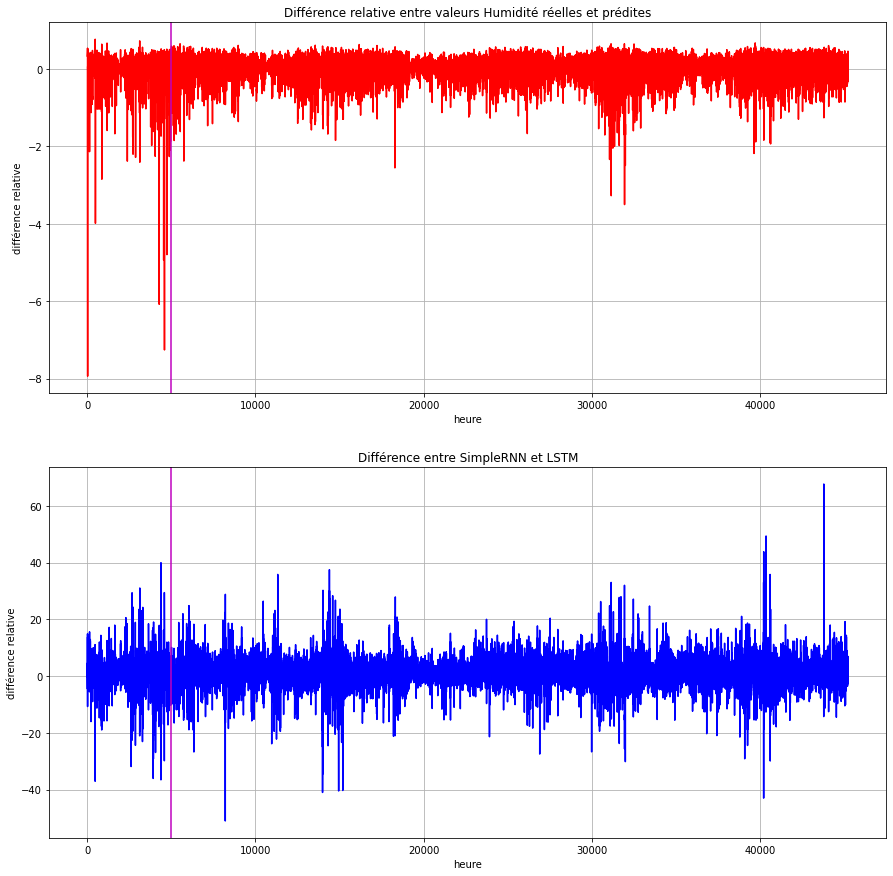

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(211)
index = humidity_M.index.values
x = np.array(humidity_M[ville]).reshape(-1,1)
max = np.max(x)
plt.title("Différence relative entre valeurs Humidité réelles et prédites")
plt.plot(index,(x-humidity_predictedLSTM)/x,'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.subplot(212)
plt.title("Différence entre SimpleRNN et LSTM")
plt.plot(index,(humidity_predicted-humidity_predictedLSTM),'b')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)

#### Comparaison GRU

In [25]:
np.random.seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

TODO

Epoch 1/20
157/157 [==============================] - 0s 3ms/step - loss: 1452.2927 - last_time_step_mse: 1446.4987
Epoch 2/20
157/157 [==============================] - 0s 3ms/step - loss: 230.3295 - last_time_step_mse: 230.1527
Epoch 3/20
157/157 [==============================] - 0s 2ms/step - loss: 161.1137 - last_time_step_mse: 160.6417
Epoch 4/20
157/157 [==============================] - 0s 2ms/step - loss: 121.2482 - last_time_step_mse: 120.9788
Epoch 5/20
157/157 [==============================] - 0s 2ms/step - loss: 95.2764 - last_time_step_mse: 95.1148
Epoch 6/20
157/157 [==============================] - 0s 2ms/step - loss: 82.2270 - last_time_step_mse: 82.0216
Epoch 7/20
157/157 [==============================] - 0s 2ms/step - loss: 88.6909 - last_time_step_mse: 88.3696
Epoch 8/20
157/157 [==============================] - 0s 2ms/step - loss: 76.4958 - last_time_step_mse: 76.3765
Epoch 9/20
157/157 [==============================] - 0s 2ms/step - loss: 70.1926 - last_time_

In [26]:
humidity_predictedGRU=np.concatenate((modelGRU.predict(humidity_trainX),
                                   modelGRU.predict(humidity_testX)),axis=0)

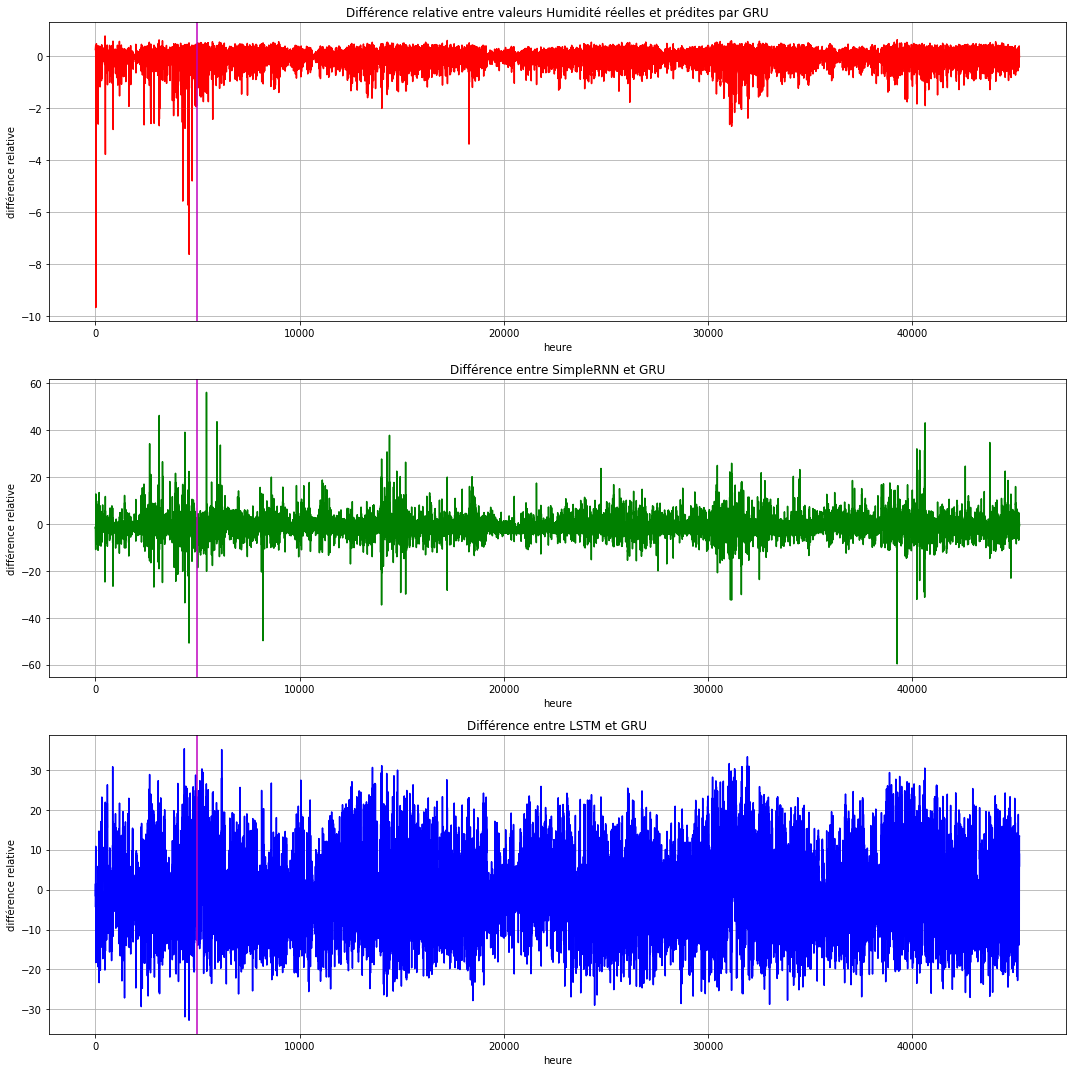

In [125]:
plt.figure(figsize=(15,15))

plt.subplot(311)
index = humidity_M.index.values
x = np.array(humidity_M[ville]).reshape(-1,1)
max = np.max(x)
plt.title("Différence relative entre valeurs Humidité réelles et prédites par GRU")
plt.plot(index,(x-humidity_predictedGRU)/x,'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.subplot(312)
plt.title("Différence entre SimpleRNN et GRU")
plt.plot(index,(humidity_predicted-humidity_predictedGRU),'g')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.subplot(313)
plt.title("Différence entre LSTM et GRU")
plt.plot(index,(humidity_predictedLSTM-humidity_predictedGRU),'b')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.tight_layout()